In [1]:
import os
import sys
sys.path.append('..\..')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from set_global_params import processed_data_path, fig4_plotting_colours, figure_directory
from bias_correlation_utils import categorise_da_responses, get_diff_in_proportion_correct, calculate_statistics, \
    calculate_psychometric, logistic
from utils.plotting_visuals import makes_plots_pretty, set_plotting_defaults
from utils.plotting import output_significance_stars_from_pval
import statsmodels.formula.api as smf
from utils.stats import cohen_d_one_sample


In [2]:
def plot_with_fitted_psychometric_curve(x, y, color=None, label=None, **kwargs):
    # Extract data from kwargs
    data = kwargs.pop("data")

    # Plotting the actual data
    sns.lineplot(x=x, y=y, data=data, label=label, color=color)

    # Getting logistic parameters for the mouse
    a, b = params_dict[data['mouse'].iloc[0]]

    # Generating the fitted curve values
    x_range = np.linspace(0, 1, 400)
    y_fit = logistic(x_range, a, b)

    # Plotting the fitted curve
    plt.plot(x_range, y_fit, color='red', linewidth=2)



In [3]:

# set some analysis parameters
slope_threshold = 1.  # slope at PSE of the psychometric function. this measures sensitivity
bias_threshold = .09  # bias of the behaviour during "easy" trials. this measures bias
# we include animals if they have a slope above the threshold AND a bias below the threshold


# Define colors for each data type
set_plotting_defaults(font_size=7)
colors = {'tail': ['#76A8DA', '#002F3A'], 'nacc': ['#F9C0AF', '#E95F32']}

coefficients_df = pd.DataFrame()
std_errors_df = pd.DataFrame()
p_vals = {}

# Set up data directory
data_dir = os.path.join(processed_data_path, 'psychometric_data')

file_paths = {'tail': os.path.join(data_dir, 'all_tail_data.csv'),
              'nacc': os.path.join(data_dir, 'nacc_data.csv')}

Analyzing site: nacc
--------------------------------------------------
Excluding mice: ['SNL_photo32' 'SNL_photo33']


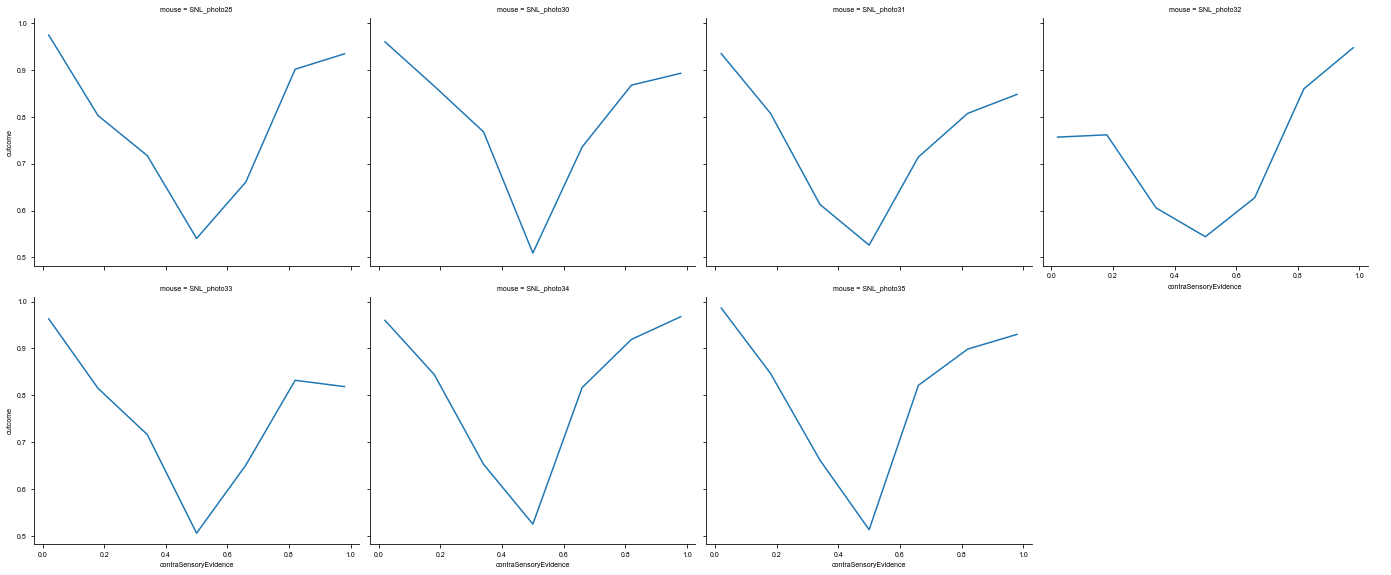

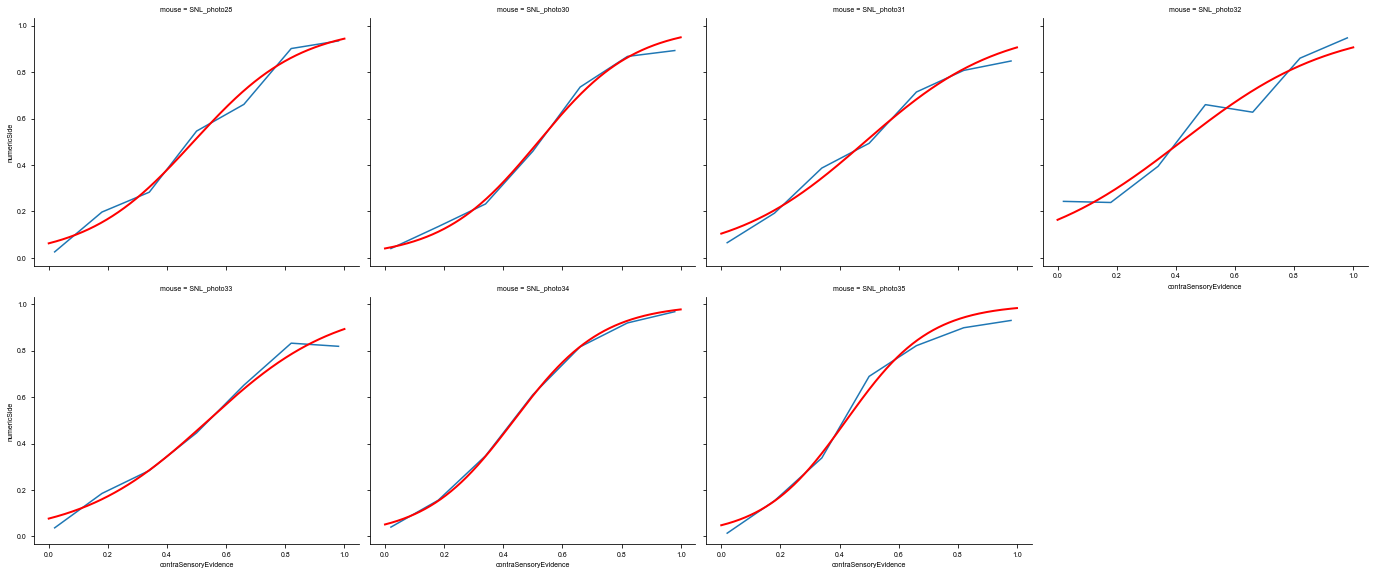

In [50]:
site = 'nacc'
print('Analyzing site: {}'.format(site))
print('-' * 50)

file_path = file_paths[site]

# set up results directory
results_dir = os.path.join(data_dir, 'logistic_regression', 'results', site)
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Load data
all_data = pd.read_csv(file_path)
df = all_data.copy()
df = calculate_statistics(df)

# ---------------------------------------------------------------
# calculate bias for each mouse
bias_df = get_diff_in_proportion_correct(df)
psymetric_df = calculate_psychometric(df)
psymetric_df.to_csv(os.path.join(results_dir, 'bias_df_{}.csv'.format(site)))

# ---------------------------------------------------------------
# show the average reward for each mouse as a function of uncertainty
# No need to filter only for correct trials here, we're including both correct and incorrect
grouped_by_mouse = df.groupby(['mouse', 'contraSensoryEvidence'])['outcome'].mean().reset_index()

# Create a line plot for each mouse
g = sns.FacetGrid(grouped_by_mouse, col="mouse", col_wrap=4, height=4, aspect=1.2)
g.map(sns.lineplot, 'contraSensoryEvidence', 'outcome')
g.add_legend()
plt.savefig(os.path.join(results_dir, 'outcome_vs_contraSensoryEvidence.png'))

# ---------------------------------------------------------------
# now show the choices for each mouse as a function of uncertainty

# No need to filter only for correct trials here, we're including both correct and incorrect
params_df = psymetric_df[['mouse', 'a', 'b']]

grouped_by_mouse = df.groupby(['mouse', 'contraSensoryEvidence'])['numericSide'].mean().reset_index()
params_dict = dict(zip(params_df['mouse'], params_df[['a', 'b']].values.tolist()))

# Create the FacetGrid
g = sns.FacetGrid(grouped_by_mouse, col="mouse", col_wrap=4, height=4, aspect=1.2)

# Mapping the modified plotting function to the FacetGrid
g.map_dataframe(plot_with_fitted_psychometric_curve, 'contraSensoryEvidence', 'numericSide')

g.add_legend()
plt.savefig(os.path.join(results_dir, 'choice_vs_contraSensoryEvidence_with_curve.png'))

# ---------------------------------------------------------------
# exclude incorrect trials and categorize DA response size
# Note, for the nacc the response is aligned to reward, so we can only use correct trials
# for the tail, the response is aligned to choice, so we use only correct trials where mice should have a bias,
# but all trials for the ambiguous stimulus (where incorrect / correct is not defined)
if site == 'tail':
    #df = df[~((df['outcome'] == 0) & (df['contraSensoryEvidence'] != 0.5))]
    df = df.reset_index()
else:
    df = df[df['outcome'] == 1].reset_index(drop=True)

#df['DAresponseSize'] = df.groupby(['mouse'])['norm APE'].apply(categorise_da_responses,
#                                                               cutoff=quantile_cutoff).reset_index(drop=True)

# ---------------------------------------------------------------
# exclude mice with low slope and large bias
mice_to_exclude = []
for mouse in psymetric_df.mouse[psymetric_df.slope < slope_threshold]:
    mice_to_exclude.append(mouse)
for mouse in bias_df.mouse[bias_df.difference > bias_threshold]:
    mice_to_exclude.append(mouse)

print('Excluding mice: {}'.format(np.unique(mice_to_exclude)))
df = df[~df.mouse.isin(mice_to_exclude)]

In [51]:
import statsmodels.api as sm
import numpy as np

# Resetting the index (if needed)
df = df.reset_index(drop=True).copy()
df['nextSideStay'] = (df['nextNumericSide'] == df['numericSide'])

# Renaming the columns
df = df.rename(columns={
    'norm APE': 'Dopamine\nresponse size',
    'log_uncertainty': 'Perceptual\nuncertainty (log)'
})

# Loop over each unique value in the 'mouse' column
unique_mice = df['mouse'].unique()
results = {}

for mouse in unique_mice:
    # Subset the data for the current mouse
    df_subset = df[df['mouse'] == mouse].copy()
    df_subset['uncertainty'] = df_subset['nextContraSensoryEvidence'].apply(
        lambda x: 1 - np.around(np.abs(0.5 - x) * 2, decimals=2)
    )
    df_subset['Perceptual\nuncertainty (log)'] = np.log(df_subset['uncertainty'])

    # Create the interaction term
    df_subset['Interaction'] = (
        df_subset['Dopamine\nresponse size'] * df_subset['Perceptual\nuncertainty (log)']
    )
    
    # Prepare the data for regression
    df_for_reg = df_subset[[
        'Dopamine\nresponse size', 
        'Perceptual\nuncertainty (log)', 
        'uncertainty', 
        'Interaction', 
        'nextNumericSide', 
        'numericSide', 
        'nextSideStay'
    ]].copy()

    y = df_for_reg['nextSideStay']
    X = sm.add_constant(df_for_reg[['Perceptual\nuncertainty (log)', 'Dopamine\nresponse size']])
    
    # Fit the logistic regression model
    logit_mod = sm.Logit(y, X)
    logit_res = logit_mod.fit(disp=0)  # Set disp=0 to suppress the output for each fit
    
    # Store the results
    results[mouse] = logit_res



cohen d:  1.4417391977590297
cohen d:  -0.542835463106403


PermissionError: [Errno 13] Permission denied: 'S:\\projects\\APE_data_francesca_for_paper\\figures\\logistic_regression_repeat_choice_Nacc.pdf'

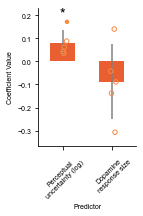

In [52]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats

if site == 'nacc':
    site = 'Nacc'
# Collect the coefficients and p-values into a DataFrame
coef_data = []
set_plotting_defaults()
# Loop through each result and collect all regressors dynamically
for mouse, result in results.items():
    data = {'Mouse': mouse}
    
    # Loop through each parameter in the result (excluding the constant term)
    for param in result.params.index:
        if param != 'const':  # Skip the constant term
            data[param] = result.params[param]
            data[f'p_{param}'] = result.pvalues[param]
    
    coef_data.append(data)

# Convert to DataFrame
coef_df = pd.DataFrame(coef_data)

# Identify all regressors dynamically (excluding Mouse and p-values)
regressors = [col for col in coef_df.columns if col not in ['Mouse'] and not col.startswith('p_')]

# Calculate the mean and standard deviation across mice for numeric columns only
coef_mean = coef_df[regressors].mean()
coef_std = coef_df[regressors].std()

# Perform a one-sample t-test against zero for each coefficient across mice
t_stats, p_values = stats.ttest_1samp(coef_df[regressors], 0)

# Create a DataFrame to store the statistics
coef_stats = pd.DataFrame({
    'Mean': coef_mean,
    'Std': coef_std,
    't-Statistic': t_stats,
    'p-Value': p_values
})

# Determine significance (p < 0.05) at the group level
coef_stats['Significant'] = coef_stats['p-Value'] < 0.05

# Plotting the coefficients with error bars
fig, ax = plt.subplots(figsize=(2, 3))

# Plot the means with error bars (standard deviations)
coef_stats['Mean'].plot(
    kind='bar',
    yerr=coef_stats['Std'], 
    capsize=0,  # Removes the caps (foot)
    ax=ax, 
    color=fig4_plotting_colours[site][0],  # Set the bar color
    error_kw={'ecolor': 'gray'}  # Sets the error bar color to gray
)

cohens = []
# Add scatter points for individual mice with jitter
jitter_strength = 0.1  # Strength of the jitter
min_ys = []
max_ys = []
for i, predictor in enumerate(regressors):
    x = np.full(len(coef_df), i) + np.random.uniform(-jitter_strength, jitter_strength, len(coef_df))  # Position scatter points with jitter
    max_y = coef_df[predictor].max()
    max_ys.append(max_y)
    min_y = coef_df[predictor].min()
    min_ys.append(min_y)
    # Determine if individual mouse coefficient is significant
    sig_mask = coef_df[f'p_{predictor}'] < 0.05
    
    # Plot filled scatter points for significant coefficients
    ax.scatter(x[sig_mask], coef_df[predictor][sig_mask], color=fig4_plotting_colours[site][1], edgecolor='none', s=20, zorder=3, label='(p < 0.05)' if i == 0 else "")
    
    # Plot unfilled scatter points for non-significant coefficients
    ax.scatter(x[~sig_mask], coef_df[predictor][~sig_mask], facecolors='none', edgecolor=fig4_plotting_colours[site][1], s=20, zorder=3, label='(p >= 0.05)' if i == 0 else "")
    stars = output_significance_stars_from_pval(coef_stats.loc[predictor]['p-Value'])
    c = cohen_d_one_sample(coef_df[predictor])
    cohens.append(c)
    ax.text(i, max_y + 0.02, stars, ha='center', fontsize=14)
coef_stats['cohens d'] = cohens

# Customize the plot
plt.ylabel('Coefficient Value')
plt.xlabel('Predictor')
if min(min_ys) < 0:
    plt.ylim([min(min_ys) - 0.06, max(max_ys)+ 0.06])
else:
    plt.ylim([0, max(max_ys)+ 0.04])
plt.xticks(rotation=45)
plt.tight_layout()
makes_plots_pretty(ax)
plt.savefig(os.path.join(figure_directory, 'logistic_regression_repeat_choice_{}.pdf'.format(site)))
# Show the plot
plt.show()

# Display the statistical significance table
print(coef_stats)


In [15]:
import statsmodels.api as sm

# Resetting the index (if needed)
df = df.reset_index(drop=True).copy()
df['nextSideStay'] = (df['nextNumericSide'] == df['numericSide'])

# Loop over each unique value in the 'mouse' column
unique_mice = df['mouse'].unique()
results = {}


for mouse in unique_mice:
    # Subset the data for the current mouse
    df_subset = df[df['mouse'] == mouse].copy()
    df_subset['uncertainty'] = df_subset['nextContraSensoryEvidence'].apply(lambda x: 1 - np.around(np.abs(.5 - x)*2, decimals=2))
    df_subset['log_uncertainty'] = df_subset['log_uncertainty'] = np.log(df_subset['uncertainty'])

    
    # Prepare the data for regression
    df_for_reg = df_subset[['norm APE', 'nextContraSensoryEvidence', 'nextNumericSide', 'numericSide', 'nextSideStay']].copy()

    y = df_for_reg['nextNumericSide']
    X = sm.add_constant(df_for_reg[['nextContraSensoryEvidence', 'norm APE']])
    
    # Fit the logistic regression model
    logit_mod = sm.Logit(y, X)
    logit_res = logit_mod.fit(disp=0)  # Set disp=0 to suppress the output for each fit
    
    # Store the results
    results[mouse] = logit_res


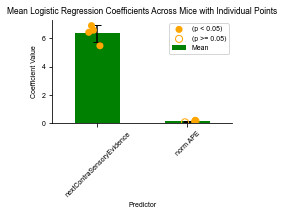

                               Mean       Std  t-Statistic   p-Value  \
nextContraSensoryEvidence  6.350105  0.612161    20.746529  0.000245   
norm APE                   0.130568  0.058647     4.452660  0.021081   

                           Significant  
nextContraSensoryEvidence         True  
norm APE                          True  


In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
set_plotting_defaults()

# Collect the coefficients and p-values into a DataFrame
coef_data = []

# Loop through each result and collect all regressors dynamically
for mouse, result in results.items():
    data = {'Mouse': mouse}
    
    # Loop through each parameter in the result (excluding the constant term)
    for param in result.params.index:
        if param != 'const':  # Skip the constant term
            data[param] = result.params[param]
            data[f'p_{param}'] = result.pvalues[param]
    
    coef_data.append(data)

# Convert to DataFrame
coef_df = pd.DataFrame(coef_data)

# Identify all regressors dynamically (excluding Mouse and p-values)
regressors = [col for col in coef_df.columns if col not in ['Mouse'] and not col.startswith('p_')]

# Calculate the mean and standard deviation across mice for numeric columns only
coef_mean = coef_df[regressors].mean()
coef_std = coef_df[regressors].std()

# Perform a one-sample t-test against zero for each coefficient across mice
t_stats, p_values = stats.ttest_1samp(coef_df[regressors], 0)

# Create a DataFrame to store the statistics
coef_stats = pd.DataFrame({
    'Mean': coef_mean,
    'Std': coef_std,
    't-Statistic': t_stats,
    'p-Value': p_values
})

# Determine significance (p < 0.05) at the group level
coef_stats['Significant'] = coef_stats['p-Value'] < 0.05

# Plotting the coefficients with error bars
fig, ax = plt.subplots(figsize=(3, 3))

# Plot the means with error bars (standard deviations)
coef_stats['Mean'].plot(kind='bar', yerr=coef_stats['Std'], capsize=4, ax=ax, color=coef_stats['Significant'].map({True: 'green', False: 'red'}))

# Add scatter points for individual mice with jitter
jitter_strength = 0.1  # Strength of the jitter

for i, predictor in enumerate(regressors):
    x = np.full(len(coef_df), i) + np.random.uniform(-jitter_strength, jitter_strength, len(coef_df))  # Position scatter points with jitter
    
    # Determine if individual mouse coefficient is significant
    sig_mask = coef_df[f'p_{predictor}'] < 0.05
    
    # Plot filled scatter points for significant coefficients
    ax.scatter(x[sig_mask], coef_df[predictor][sig_mask], color='orange', edgecolor='none', s=50, zorder=3, label='(p < 0.05)' if i == 0 else "")
    
    # Plot unfilled scatter points for non-significant coefficients
    ax.scatter(x[~sig_mask], coef_df[predictor][~sig_mask], facecolors='none', edgecolor='orange', s=50, zorder=3, label='(p >= 0.05)' if i == 0 else "")

# Customize the plot
plt.title('Mean Logistic Regression Coefficients Across Mice')
plt.ylabel('Coefficient Value')
plt.xlabel('Predictor')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
makes_plots_pretty(ax)
# Show the plot
plt.show()

# Display the statistical significance table
print(coef_stats)

In [436]:
coef_df


,Mouse,log_uncertainty,p_log_uncertainty,norm APE,p_norm APE,Interaction,p_Interaction
0,SNL_photo21,0.025175,0.664191,0.162867,0.029454,0.052171,0.181942
1,SNL_photo22,0.098279,0.118429,0.164997,0.078409,0.016489,0.740694
2,SNL_photo26,0.218859,0.000057,-0.032555,0.597043,-0.049343,0.144495
3,SNL_photo57,0.194068,0.000449,0.019713,0.768818,-0.057693,0.114507


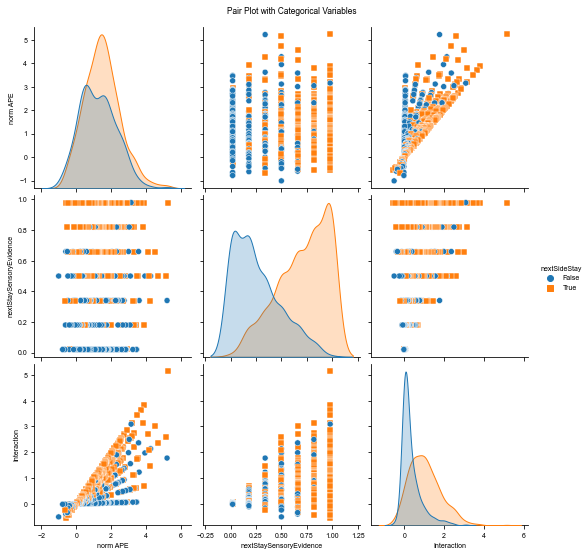

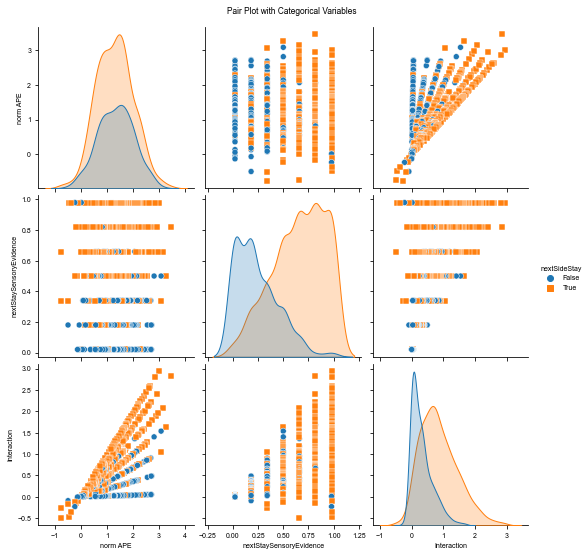

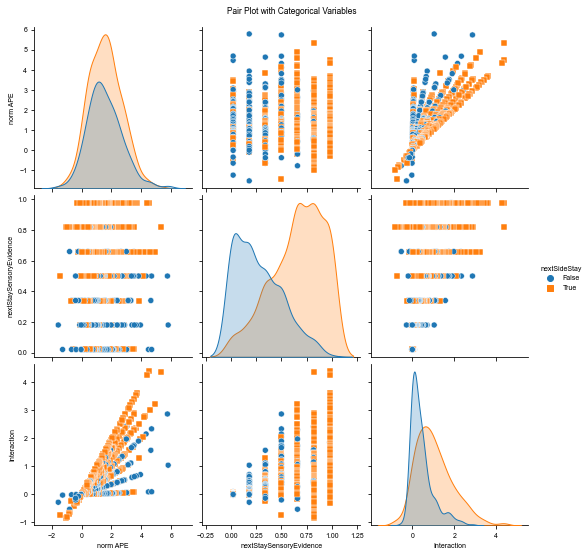

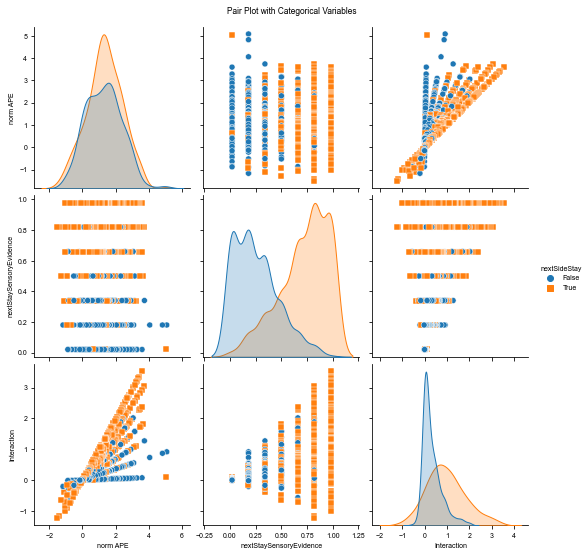

In [357]:
import seaborn as sns

# Resetting the index (if needed)
df = df.reset_index(drop=True).copy()
df['nextSideStay'] = (df['nextNumericSide'] == df['numericSide'])

# Loop over each unique value in the 'mouse' column
unique_mice = df['mouse'].unique()
# Create the new column 'staySensoryEvidence' with the transformation applied
df['nextStaySensoryEvidence'] = df['nextContraSensoryEvidence']

# Apply the transformation to the new column where df['numericSide'] == 0
df.loc[df['numericSide'] == 0, 'nextStaySensoryEvidence'] = 1 - df.loc[df['numericSide'] == 0, 'nextContraSensoryEvidence']

for mouse in unique_mice:
    # Subset the data for the current mouse
    df_subset = df[df['mouse'] == mouse].copy()
    df_subset = df_subset[df_subset['numericSide'] == 1]
    
    
    # Create the interaction term
    df_subset['Interaction'] = df_subset['norm APE'] * df_subset['nextStaySensoryEvidence']
    
    # Prepare the data for regression
    df_for_reg = df_subset[['norm APE', 'nextStaySensoryEvidence', 'Interaction', 'nextSideStay']].copy()
    #df_for_reg.loc[:, 'nextNumericSide'] = df_for_reg['nextSideStay'].astype(bool)
    # Convert boolean columns to categorical for hue
    df_for_plot = df_for_reg.copy()
    bool_columns = df_for_plot.select_dtypes(include=[bool]).columns
    df_for_plot[bool_columns] = df_for_plot[bool_columns].astype('category')

    # Pair plot with categorical hue (boolean variables)
    sns.pairplot(df_for_plot, hue=bool_columns[0], diag_kind='kde', markers=['o', 's'])
    plt.suptitle('Pair Plot with Categorical Variables', y=1.02)
    plt.show()
